# Causal effect variational autoencoder

The idea here is based on C. Louizos, U. Shalit, J. Mooij, D. Sontag, R. Zemel, M. Welling (2017).
    "Causal Effect Inference with Deep Latent-Variable Models."
    http://papers.nips.cc/paper/7223-causal-effect-inference-with-deep-latent-variable-models.pdf

## What is this for?

Suppose we observe some outcomes $y$ that are directly dependent upon an observed (not exogenous) intervention/treatment $t$ and in some way related to some observed features $x$. If we want to determine the effect of $t$ on $y$, a simple approach is to simply assume that $y$ is directly related to $t$ and $x$, e.g. by the linear model
$$y_i = \alpha + \sum \beta_j x_{i,j} + \gamma t_i + \epsilon_i$$
and then assume that the average treatment effect of $t$ on $y$ is the estimated parameter $\hat{\gamma}$. However, this ignores the fact that there are likely unobserved confounding variables that affect $x$, $y$, and $t$ and would bias an estimate that does not take them in to account. If we label the unobserved confounding variables as $z$, we can model $x$ and $t$ as random vectors dependent on $z$, and $x$ as a random vector dependent on $z$ and $t$. That is,
$$x \sim p(x | z)$$
$$t \sim p(t | z)$$
$$y \sim p(y | z, t)$$
If we know these distributions and the distribution of $z$ we can then estimate the individual treatment effect
$$ITE(x) = \text{E} [y | x, t=1] - \text{E} [y | x, t=0]$$
and the average treatment effect
$$ATE = \text{E}_x [ITE(x)].$$
We don't know the exact form of the confounding variables $z$, nor do we know the form of the distributions of $x$, $t$ and $y$, so we have to take a clever approach to approximate them: we assume $z$ to be some random vector of reasonably high dimension (high enough to capture a range of possible confounding factors), over which we set a prior probability distribution. We then assume that the distributions for our other variables take the form
$$x \sim p(x | f_x(z))$$
$$t \sim p(t | f_t(z))$$
$$y \sim p(y | (1-t) f_{y0}(z) + t f_{y1}(z))$$
where each of $f_x$, $f_t$, $f_{y0}$, and $f_{y1}$ are neural networks that take the $z$ as inputs and output parameters for some flexible probability distribution (e.g. they could output location and scale parameters for a multivariate normal distribution). We do this because we do not know the proper form for the distributions in question, but neural networks provide a very flexible approximation to an arbitrary nonlinear function, with the only downside being that we need a rather large amount of data to fit them accurately. Notice that the distribution for $y$ assumes different parameters depending on whether the datum in question has $t=1$ or $t=0$ (received the treatment or not).

To explore the posterior distribution for $z$ (which, again, we need to do in order to estimate the treatment effect), sequential Monte Carlo methods are probably not going to work since there are so many parameters involved, so we use variational inference instead. We define variational distributions for each random variable, with the form of the variational distributions analogous to the above modeled distributions (i.e. we again use neural networks to parameterize the distributions). We can then fit the model by simultaneously fitting the component neural networks and minimizing the "distance" between the variational distribution and the true posterior distribution (by effectively minizing the KL divergence between the two, or equivalently maximizing the ELBO -- the form of the ELBO used here is a little different that what is typically used in other variational inference problems; see the linked paper for details).

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.cevae import CEVAE

import statsmodels.api as sm
from statsmodels.miscmodels.tmodel import TLinearModel
import numpy as np
import matplotlib.pyplot as plt
from seaborn import kdeplot

We can test this out on a toy data set:

In [2]:
# Create a toy data set -- the choice of variables here is somewhat arbitrary;
    # it's just meant to provide a reasonably complicated example problem

N_DATA = 1000
N_FEATURES = 5
pyro.set_rng_seed(152)

def gen_data():
    # Generate confounding variables z
    z = dist.Normal(0, 1).sample([N_DATA, 3])
    # Generate observed features x as a function of z
    x = torch.empty([N_DATA, N_FEATURES])
    for i in range(N_FEATURES):
        x[:,i] = dist.Normal(i*z[:,0] + 2*z[:,1] + 3*z[:,2], z.mean(axis=1)).sample()
    # Generate treatments t as a function of z
    t = dist.Bernoulli(logits=1+z.mean(axis=1)).sample()
    # Generate outcomes as a function of z and t
    y = dist.StudentT(df=5, loc=z[:,0] - z[:,1]**3 + 0.5*t*z[:,2]**2, scale=torch.abs(z[:,0]+1)).sample()
    return z, x, t, y

z, x, t, y = gen_data()

# estimate true individual/average treatment effect
t01 = torch.tensor([[0], [1]]) 
y_t0, y_t1 = dist.StudentT(df=5, loc=z[:,0] - z[:,1]**3 + 0.5*t01*z[:,2]**2,
                           scale=torch.abs(z[:,0]+1)).mean
ite = y_t1 - y_t0
ate = ite.mean()  # note we can actually compute exact ate here; it's 0.5
print('Average treatment effect is', ate.item())

Average treatment effect is 0.49032869935035706


We can try estimating the treatment effect using a linear regression:

In [3]:
# Assemble matrix of features
X = np.concatenate((np.ones(N_DATA).reshape(-1, 1), np.array(x), np.array(t).reshape(-1, 1)), axis=1)
# Fit with statsmodels
reg_fit = sm.OLS(np.array(y), X).fit()
print(reg_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     41.20
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           5.85e-45
Time:                        10:59:12   Log-Likelihood:                -2825.0
No. Observations:                1000   AIC:                             5664.
Df Residuals:                     993   BIC:                             5698.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1357      0.249     -0.545      0.5

Here the coefficient for the $t$ (`x6` in the table above) is not statistically significant; a linear regression fails to separate the effects of the treatment from the other observed variables. Part of this is just due to a misspecification problem: OLS assumes that errors are normally distributed, but here errors are Student's t-distributed. We can address this by estimating the model with assumed Student's t errors, using maximum likelihood estimation:

In [4]:
regT_fit = TLinearModel(np.array(y), X).fit(method='bfgs')
print(regT_fit.summary())

Optimization terminated successfully.
         Current function value: 2.511776
         Iterations: 36
         Function evaluations: 40
         Gradient evaluations: 40
                             TLinearModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -2511.8
Model:                   TLinearModel   AIC:                             5038.
Method:            Maximum Likelihood   BIC:                             5072.
Date:                Thu, 23 Apr 2020                                         
Time:                        10:59:12                                         
No. Observations:                1000                                         
Df Residuals:                     993                                         
Df Model:                           6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

This model estimates a positive effect size, but it's still not statistically significant at any meaningful level. The other disadvantage is that we only get an estimate of the average effect size, not the individual effect sizes. Let's see how the causal effect variational autoencoder works here (using the contributed `CEVAE` class from the Pyro project):

In [5]:
# create and train the CEVAE model
LATENT_DIM = 10  # dimension of representation of confounders
HIDDEN_DIM = 100  # size of hidden layers in neural nets
N_LAYERS = 3  # number of layers in neural nets
N_EPOCHS = 150  # number of full training loops through the data

pyro.clear_param_store()
cevae = CEVAE(
    feature_dim=N_FEATURES,
    outcome_dist='studentt',
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=N_LAYERS
)
cevae.fit(x, t, y, num_epochs=N_EPOCHS)
# estimate individual treatment effects and average treatment effect
ite_estimate = cevae.ite(x)
ate_estimate = ite_estimate.mean()
print('estimated ATE:', ate_estimate.item())

INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches


estimated ATE: 0.3664555251598358


The estimated average treatment effect is lower than the true ATE. However, the sign is correct and the magnitude is about right. We can look at the distributions of the true and estimated treatment effects to see how similar the two are:

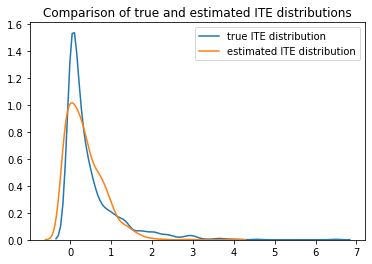

In [6]:
kdeplot(np.array(ite), label='true ITE distribution')
kdeplot(np.array(ite_estimate), label='estimated ITE distribution')
plt.title('Comparison of true and estimated ITE distributions')
plt.show()

This is really not all too bad given that this model did not assume any information about the form of the confounders and their relationship with the observed variables. Theoretically, given enough data and sufficiently sophisticated parameterization neural nets, it should be possible to get very good predictions of the treatment effect.

One question we might ask is how confident this estimate is. The $z$ are estimated as random variables, so we can re-calculate the estimated ATE multiple times and see how much it varies.

INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 E

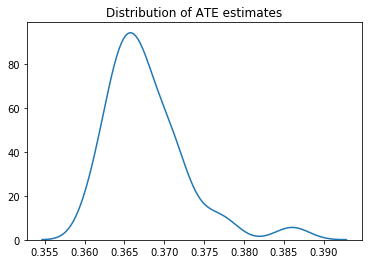

In [7]:
ate_estimates = np.array([cevae.ite(x, num_samples=10).mean().item() for _ in range(100)])

kdeplot(ate_estimates)
plt.title('Distribution of ATE estimates')
plt.show()

A better test might be to generate test sets and calculate the ATE on those sets:

INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 Evaluating 1 minibatches
INFO 	 E

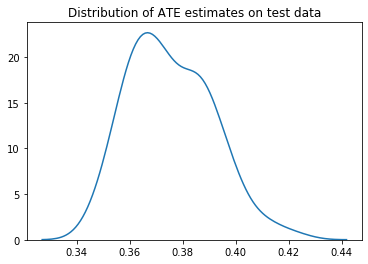

In [8]:
ate_test_estimates = np.empty(100)
for i in range(100):
    _, x_test, _, _ = gen_data()
    ate_test_estimates[i] = cevae.ite(x_test, num_samples=10).mean().item()

kdeplot(ate_test_estimates)
plt.title('Distribution of ATE estimates on test data')
plt.show()